This notebook needs "stat165_athletics_wr_data.csv" to be in its directory.

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re

import warnings
warnings.filterwarnings('ignore')

# preprocessing

skip until simulation section to get past this annoying bs.

In [21]:
df = pd.read_csv("stat165_athletics_wr_data.csv")
df = df[[col for col in df.columns if "Unnamed:" not in col]]
df

,event,gender,time_distance,athlete,location,date
0,100m,M,10.06,Bob Hayes,"Tokyo, Japan","October 15, 1964"
1,100m,M,10.03,Jim Hines,"Sacramento, USA","June 20, 1968"
2,100m,M,10.02,Charles Greene,"Mexico City, Mexico","October 13, 1968"
3,100m,M,9.95,Jim Hines,"Mexico City, Mexico","October 14, 1968"
4,100m,M,9.93,Calvin Smith,"Colorado Springs, USA","July 3, 1983"
...,...,...,...,...,...,...
1994,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
minimal_df = df[['event', 'gender', 'date']].dropna(subset=['date'])
minimal_df['date'] = minimal_df.date.fillna(method='ffill')
minimal_df

,event,gender,date
0,100m,M,"October 15, 1964"
1,100m,M,"June 20, 1968"
2,100m,M,"October 13, 1968"
3,100m,M,"October 14, 1968"
4,100m,M,"July 3, 1983"
...,...,...,...
1460,Women's 4 x 400m relay,F,1972-09-10
1461,Women's 4 x 400m relay,F,1976-07-31
1462,Women's 4 x 400m relay,F,1982-09-11
1463,Women's 4 x 400m relay,F,1984-06-03


In [23]:
dates = minimal_df.date.values.tolist()
dates = [re.sub(r'\[.*?\]', '', date) for date in dates]

def convert_to_iso_format(date_str):
    try:
        # Try parsing date with different formats
        date_obj = datetime.strptime(date_str, "%d %B %Y")
    except ValueError:
        try:
            date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        except ValueError:
            try:
                date_obj = datetime.strptime(date_str, "%B %d, %Y")
            except ValueError:
                try:
                    # Try parsing date with different formats
                    date_obj = datetime.strptime(date_str, "%d %b %Y")
                except ValueError:
                    # If date format is not recognized, return None
                    return None
    return date_obj.strftime("%Y-%m-%d")

# Convert dates to YYYY-MM-DD format
converted_dates = []
for idx, date_str in enumerate(dates):
    converted_date = convert_to_iso_format(date_str)
    if converted_date:
        converted_dates.append(converted_date)
    else:
        print(idx, date_str)

minimal_df['date'] = converted_dates

In [24]:
master_list = []
minimal_df['full_event_name'] = minimal_df.event + '_' + minimal_df.gender

for key in minimal_df.full_event_name.unique():
    temp_df = minimal_df[minimal_df.full_event_name == key]
    dates = pd.to_datetime(temp_df.date[::-1])
    date_diff = dates.diff()
    date_diff_days = (-date_diff.dt.days).tolist()[::-1]
    
    given_date = datetime.strptime(temp_df.date.values[-1], "%Y-%m-%d")
    today_date = datetime.now()
    days_difference = abs((given_date - today_date).days)
    date_diff_days[-1] = days_difference
    
    temp_df['diff'] = date_diff_days
    master_list.append(temp_df)

diff_df = pd.concat(master_list, axis=0)
diff_df

,event,gender,date,full_event_name,diff
0,100m,M,1964-10-15,100m_M,1344.0
1,100m,M,1968-06-20,100m_M,115.0
2,100m,M,1968-10-13,100m_M,1.0
3,100m,M,1968-10-14,100m_M,5375.0
4,100m,M,1983-07-03,100m_M,1519.0
...,...,...,...,...,...
1460,Women's 4 x 400m relay,F,1972-09-10,Women's 4 x 400m relay_F,1420.0
1461,Women's 4 x 400m relay,F,1976-07-31,Women's 4 x 400m relay_F,2233.0
1462,Women's 4 x 400m relay,F,1982-09-11,Women's 4 x 400m relay_F,631.0
1463,Women's 4 x 400m relay,F,1984-06-03,Women's 4 x 400m relay_F,1581.0


# simulation

example: using `diff_df` to get the data for Men's 100m: interpret each row as the WR established on `date` lasted for `diff` days.

In [25]:
mens100m = diff_df.loc[((diff_df.event == '100m') & (diff_df.gender == 'M')), ['date', 'diff']]
event = mens100m[mens100m['diff'] != 0]
event

,date,diff
0,1964-10-15,1344.0
1,1968-06-20,115.0
2,1968-10-13,1.0
3,1968-10-14,5375.0
4,1983-07-03,1519.0
6,1987-08-30,353.0
7,1988-08-17,38.0
9,1988-09-24,993.0
10,1991-06-14,72.0
11,1991-08-25,1046.0


# Simulation 1
see paper for justification and assumptions.

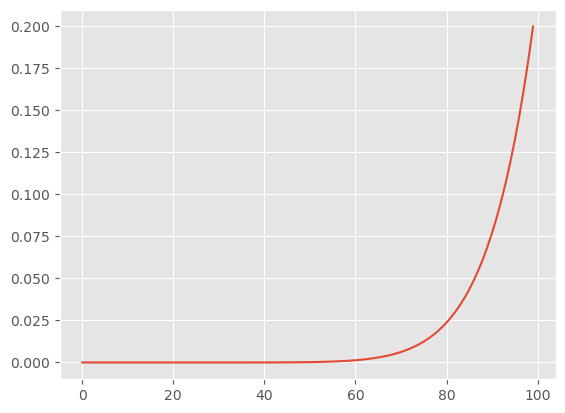

In [26]:
x =  np.linspace(0, 1, 100)
plt.plot(x**10 / 5)

In [27]:
def compute_p_records_per_year(event, start_year=1999):
    """
        interpret results as the proportion of 1 year periods (since first WR) containing a new WR
        restrict to only this century to account for technological advances
    """
    records = event.date.str.split('-', n=2, expand=True)[0].astype(int)
    records = records[records >= start_year]
    
    if len(records) == 0:
        a = start_year
        answer = 1
    else:
        a = np.min(records)
        answer = max(1, len(records.unique()))
        
    return answer / (2023 - a)

def compute_probability(event, start_year=1999):
    """
        interpret result as prob of record breaking at this Olympics
    """
    likelihood = event.iloc[-1]['diff'] 
    multiplier = np.mean(likelihood > event.iloc[:-1]['diff'])
    max_penalty = 0.2
    penalty = max_penalty * (multiplier ** 10) # penalty term to decrease P if current WR has been active for a long time relative to past
    
    prior = compute_p_records_per_year(event, start_year=start_year) # P 2024 sees a WR given the past 25 years
    
    p_hat = prior - penalty
        
    answer = min(0.5, p_hat)
    answer = max(answer, 0.01)
    
    return answer

def get_all_events(df, start_year=1999):
    events = []
    ps = []
    for event in diff_df.full_event_name.unique():
        temp = df[df.full_event_name==event]
        temp = temp[temp['diff'] != 0]
        p_hat = compute_probability(temp, start_year=start_year)
        ps.append(p_hat)
        events.append(event)
    return ps, events

In [28]:
p_hats, events = get_all_events(diff_df, 1989)
simulation = np.random.rand(1500, len(p_hats)) < np.array(p_hats)
sums = np.sum(simulation, axis=1)
print(np.quantile(sums, (0.1, 0.85)))

[3. 7.]


In [29]:
# TODO: screenshot later
table2 = pd.DataFrame(data={"event" : events, "probability" : p_hats}).sort_values(by="probability", ascending=False)
table2[['event', 'gender']] = table2.event.str.split('_', expand=True)
table2[['event', 'gender', 'probability']].reset_index(drop=True)

,event,gender,probability
0,marathon,M,0.480000
1,marathon,F,0.400000
2,3000m steeplechase,F,0.302515
3,10000m,M,0.290151
4,5000m,F,0.285713
5,100m hurdles,F,0.285654
6,20km walk,F,0.284505
7,hammer,F,0.282759
8,pole vault,M,0.250000
9,pole vault,F,0.219355


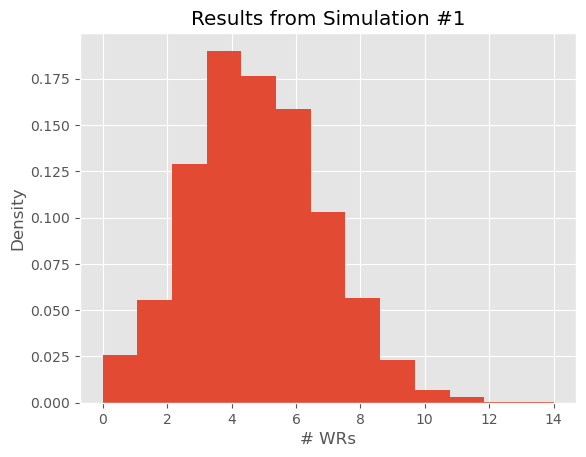

In [30]:
# TODO: screenshot for later
plt.hist(sums, bins=13, density=True)
plt.xlabel("# WRs")
plt.ylabel("Density")
plt.title("Results from Simulation #1");

In [31]:
# how changing start - year affects the expected number of WRs
def test(df):
    xs = []
    for start in np.arange(1900, 2000):
        x_hat = np.sum(get_all_events(df, start_year=start))
        xs.append(x_hat)
    plt.plot(xs)

In [32]:
test(diff_df)

TypeError: cannot perform reduce with flexible type

# Simulation 2

In [49]:
table2['event_w_gender'] = table2['event'] + "_" + table2['gender']
table3 = table2.sort_values('event').reset_index(drop = True)
table3

,event,probability,gender,event_w_gender
0,10000m,0.290151,M,10000m_M
1,10000m,0.094350,F,10000m_F
2,100m,0.112500,M,100m_M
3,100m,0.010000,F,100m_F
4,100m hurdles,0.285654,F,100m hurdles_F
5,110m hurdles,0.020231,M,110m hurdles_M
6,1500m,0.010000,M,1500m_M
7,1500m,0.099805,F,1500m_F
8,200m,0.089636,M,200m_M
9,200m,0.010000,F,200m_F


$$k = \sum_{n=1}^{45} D_i $$ 

In [51]:
table3['probability'] = 3/92
table3

,event,probability,gender,event_w_gender
0,10000m,0.032609,M,10000m_M
1,10000m,0.032609,F,10000m_F
2,100m,0.032609,M,100m_M
3,100m,0.032609,F,100m_F
4,100m hurdles,0.032609,F,100m hurdles_F
5,110m hurdles,0.032609,M,110m hurdles_M
6,1500m,0.032609,M,1500m_M
7,1500m,0.032609,F,1500m_F
8,200m,0.032609,M,200m_M
9,200m,0.032609,F,200m_F


In [71]:
table3.loc[table3['event_w_gender'] == 'pole vault_M', 'probability'] = 3/92 + 0.2
table3.loc[table3['event_w_gender'] == '3000m steeplechase_M', 'probability'] = 3/92 + 0.1
table3.loc[table3['event_w_gender'] == '1500m_F', 'probability'] = 3/92 + 0.2
table3.loc[table3['event_w_gender'] == '5000m_F', 'probability'] = 3/92 + 0.2
table3.loc[table3['event_w_gender'] == '400m_F', 'probability'] = 3/92 + 0.3
table3.loc[table3['event_w_gender'] == 'marathon_F', 'probability'] = 3/92 + 0.15
table3.loc[table3['event_w_gender'] == '100m hurdles_F', 'probability'] = 3/92 + 0.15
table3.loc[table3['event_w_gender'] == '100m_F', 'probability'] = 3/92 + 0.1
table3.loc[table3['event_w_gender'] == 'shot put_M', 'probability'] = 3/92 + 0.2

table3.sort_values('probability', ascending = False).reset_index(drop = True)

,event,probability,gender,event_w_gender
0,400m,0.332609,F,400m_F
1,shot put,0.232609,M,shot put_M
2,1500m,0.232609,F,1500m_F
3,pole vault,0.232609,M,pole vault_M
4,5000m,0.232609,F,5000m_F
5,100m hurdles,0.182609,F,100m hurdles_F
6,marathon,0.182609,F,marathon_F
7,3000m steeplechase,0.132609,M,3000m steeplechase_M
8,100m,0.132609,F,100m_F
9,javelin,0.032609,F,javelin_F


In [72]:
columns = table3['event_w_gender']

# Probabilities
probabilities = np.array(table3['probability'])

# Number of simulations
num_simulations = 10000

# Initialize an array to store the results of each simulation
simulation_results = np.zeros((num_simulations, len(probabilities)))

# Perform simulations
for i in range(num_simulations):
    simulation_results[i, :] = np.random.binomial(n=1, p=probabilities, size=len(probabilities))

# Add a column to store the sum of each row (the total number of events that occurred)
sums = simulation_results.sum(axis=1)
simulation_df = pd.DataFrame(simulation_results, columns=columns)
simulation_df['Sum'] = sums

# Checking the first few simulations with the total events count
simulation_df.head()

event_w_gender,10000m_M,10000m_F,100m_M,100m_F,100m hurdles_F,110m hurdles_M,1500m_M,1500m_F,200m_M,200m_F,...,long jump (low altitude)_M,marathon_M,marathon_F,pole vault_M,pole vault_F,shot put_M,shot put_F,triple jump_F,triple jump_M,Sum
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


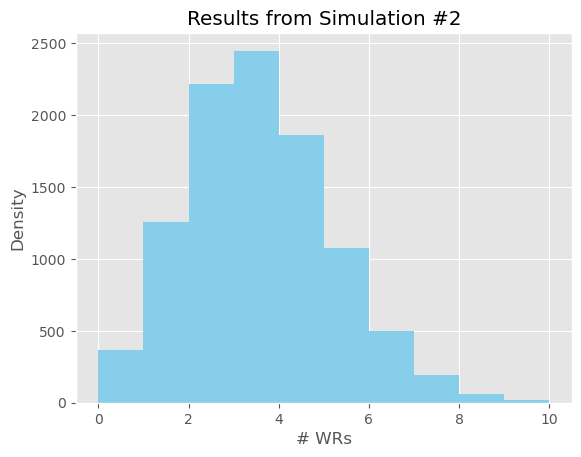

In [73]:
plt.hist(simulation_df['Sum'], color = 'skyblue')
plt.xlabel("# WRs")
plt.ylabel("Density")
plt.title("Results from Simulation #2");

In [74]:
print(np.quantile(simulation_df['Sum'], (0.1, 0.9)))

[1. 5.]
